In [348]:
#Import neccessary modules and load the dataset using Pandas
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import re

In [349]:
# The dataset was unzipped and moved to the folder "Dataset" in this directory

trainingSet = pd.read_csv("Dataset/mediaeval-2015-trainingset.txt", sep='\t')
testSet = pd.read_csv("Dataset/mediaeval-2015-testset.txt", sep='\t')

# Creating DataFrames for training and testing
df_train = pd.DataFrame(data = trainingSet)
df_test = pd.DataFrame(data = testSet)

<h1>Data Characterisation

In [350]:
# See structure and column information of trainingSet
trainingSet.info()
testSet.info()
trainingSet.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


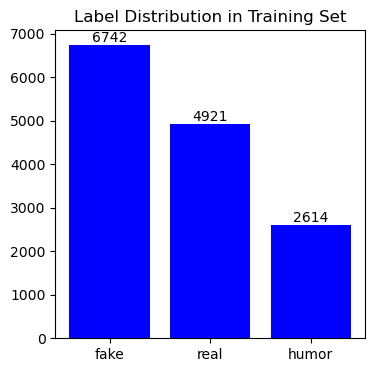

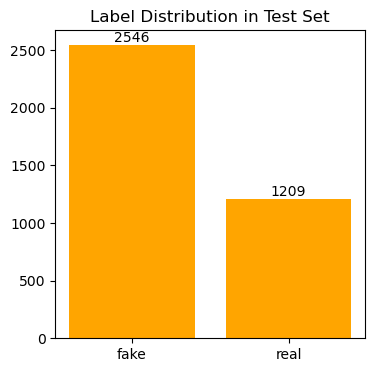

In [351]:
# Get unique values in label in training set
label_counts = df_train['label'].value_counts()

# Plot for the training set
plt.figure(figsize=(4, 4))
bars = plt.bar(label_counts.index, label_counts.values, color='blue')
plt.title('Label Distribution in Training Set')

# Add labels on each bar with frequencies
for bar, name, frequency in zip(bars, label_counts.index, label_counts.values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{frequency}', ha='center', va='bottom')

plt.show()

# Get unique values in label in test set
label_counts_test = df_test['label'].value_counts()

# Plot for the test set
plt.figure(figsize=(4, 4))
bars = plt.bar(label_counts_test.index, label_counts_test.values, color='orange')
plt.title('Label Distribution in Test Set')

# Add labels on each bar with frequencies
for bar, name, frequency in zip(bars, label_counts_test.index, label_counts_test.values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{frequency}', ha='center', va='bottom')
    
plt.show()

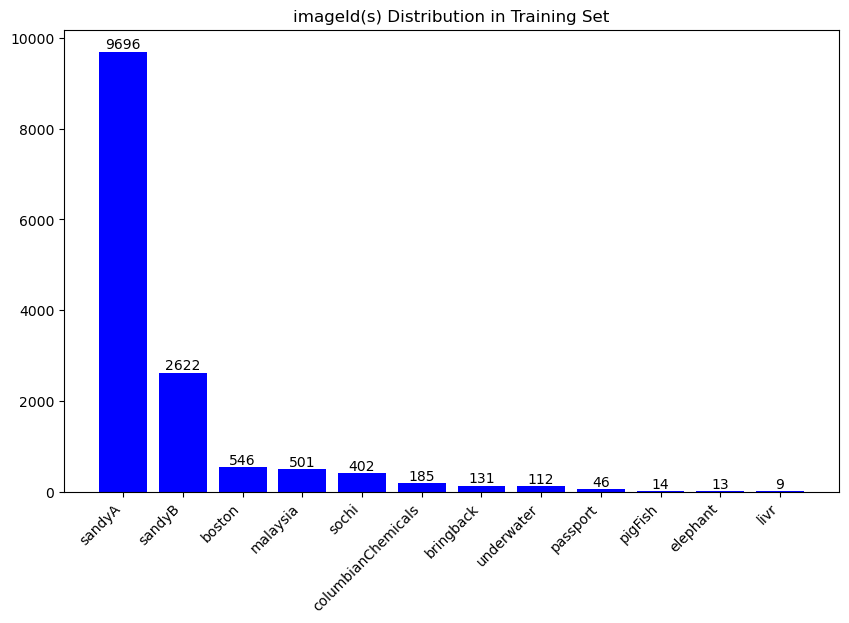

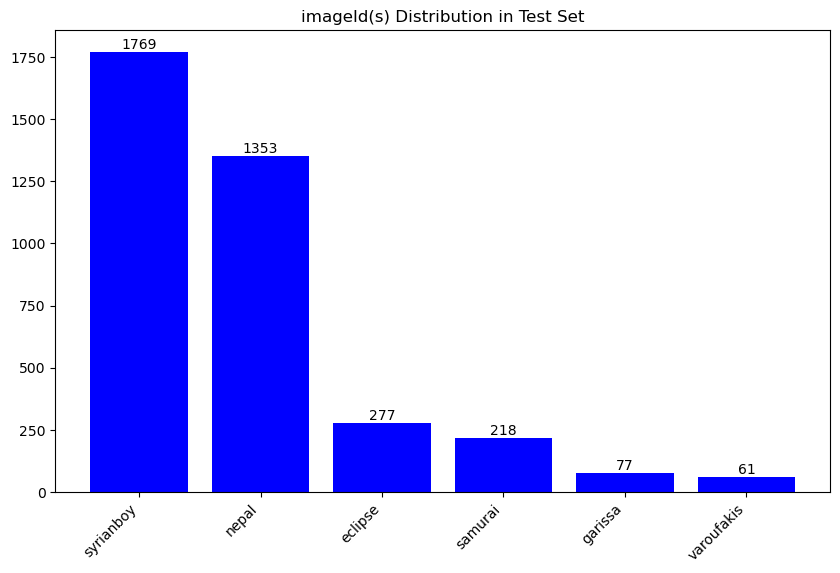

In [352]:
# Get unique values in imageId(s) excluding the number
unique_imageIds = df_train['imageId(s)'].str.split('_').str[:1].apply('_'.join).value_counts()
unique_imageIds_test = df_test['imageId(s)'].str.split('_').str[:1].apply('_'.join).value_counts()

# Plot for the training set with labels on bars
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_imageIds.index, unique_imageIds.values, color='blue')
plt.title('imageId(s) Distribution in Training Set')
plt.xticks(rotation=45, ha='right')

# Add labels on each bar with frequencies
for bar, name, frequency in zip(bars, unique_imageIds.index, unique_imageIds.values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{frequency}', ha='center', va='bottom')

plt.show()

# Plot for the test set with labels on bars
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_imageIds_test.index, unique_imageIds_test.values, color='blue')
plt.title('imageId(s) Distribution in Test Set')
plt.xticks(rotation=45, ha='right')

# Add labels on each bar with frequencies
for bar, name, frequency in zip(bars, unique_imageIds_test.index, unique_imageIds_test.values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{frequency}', ha='center', va='bottom')

plt.show()

In [353]:
# Detect language for each tweet, output as json object
##def detect_language(text):
  ##  try:
    #    return detect(text) if text else 'Unknown'
    #except:
     #   return 'Unknown'

#tweetLang = df_train['tweetText'].apply(detect_language)

#language_counts = tweetLang.value_counts()

#print(language_counts.to_dict())

<h1>Data Pre-processing

In [354]:
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [355]:
# Turn humor values in "label" to fake
df_train['label'] = df_train['label'].replace('humor', 'fake')

# Rename "imageId(s)" to "imageId"
df_train = df_train.rename(columns={'imageId(s)': 'imageId'})
df_test = df_test.rename(columns={'imageId(s)': 'imageId'})

In [356]:
# Remove tags/mentions and retweets
mentionRegex = r"(via @\w+)|(via+\s+/r/[A-Za-z]+)|(via \w+)|(@\w+)|RT|&amp"

df_train['tweetText'] = df_train['tweetText'].apply(lambda text: re.sub(mentionRegex, '', text))
df_test['tweetText'] = df_test['tweetText'].apply(lambda text: re.sub(mentionRegex, '', text))

username: seanpizzy	weetText: : Dad left stranded in South Korea after his toddler did this to his passport... http://t.co/xjWjcb6AoE http://t.co/aR7yfIoFII

username: JWintin	weetText: Funny   Dad left stranded in SKorea after his toddler did this to his passport. http://t.co/Umj5izuJ2s  http://t.co/LUMGJqNVVZ

username: KevonMiller85	weetText: “: Dad left stranded in South Korea after his toddler did this to his passport... http://t.co/UhhsOIM4rK” MATE!!! 🙊🙉🙈

username: vishnusuresh	weetText:  : Dad left stranded in South Korea after his toddler did this to his passport   http://t.co/XNi10t5Tw5   http://t.co/Ng7ineOTjI

username: clairwithnoe	weetText: “: Dad stranded in South Korea after his toddler did this to his passport http://t.co/hxOJWm3N0U http://t.co/iIf0UxCyEY” hahaha!

username: HoneyInJozi	weetText: CREATIVITY!  : Dad left stranded in South Korea after his toddler did this to his passport.. http://t.co/LV83SurnAr

username: AndyBlackAssoc	weetText: Dad left stranded in So

In [357]:
# Remove all links
urlRegex = re.compile(r'http[s]?://\S+')

df_train['tweetText'] = df_train['tweetText'].apply(lambda text: re.sub(urlRegex, '', text))
df_test['tweetText'] = df_test['tweetText'].apply(lambda text: re.sub(urlRegex, '', text))

In [358]:
# Remove emojis
# code section from https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       "]+", flags=re.UNICODE)

def remove_emojis(text):
    if isinstance(text, str):
        cleaned_text = emoji_pattern.sub('', text)
        return cleaned_text
    else:
        return text

# Assuming df_train is your DataFrame
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: remove_emojis(text) if text else text)
df_test['tweetText'] = df_test['tweetText'].apply(lambda text: remove_emojis(text) if text else text)

In [359]:
# Noise removal (unnecessary characters such as punctuation and special characters)
removeChars = '#.!():",_-;<>«“?*=❤•☁|▶✨☝⚡☔✈️❗�¿/+\n'
def removeNoise(text):
    if isinstance(text, str):
        return re.sub(f'[{re.escape(removeChars)}]', '', text)
    return text

df_train['tweetText'] = df_train['tweetText'].apply(removeNoise)
df_test['tweetText'] = df_test['tweetText'].apply(removeNoise)

# Remove links that had whitespace and newline characters
urlRegex = re.compile(r'http \\\\tco\\\S+')

df_train['tweetText'] = df_train['tweetText'].apply(lambda text: re.sub(urlRegex, '', text))
df_test['tweetText'] = df_test['tweetText'].apply(lambda text: re.sub(urlRegex, '', text))

In [360]:
# Remove stop words
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to the 'tweetText' column in your DataFrame
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: remove_stopwords(text))
df_test['tweetText'] = df_test['tweetText'].apply(lambda text: remove_stopwords(text))

In [361]:
# Remove newline character
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: re.sub(r'\\n', '', text))
df_test['tweetText'] = df_test['tweetText'].apply(lambda text: re.sub(r'\\n', '', text))

# Remove whitespace
df_train['tweetText'] = df_train['tweetText'].str.replace(r'\s+', ' ', regex=True).str.strip()
df_test['tweetText'] = df_test['tweetText'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [362]:
# Turn text to lowercase
df_train['tweetText'] = df_train['tweetText'].apply(lambda text: text.lower())
df_test['tweetText'] = df_test['tweetText'].apply(lambda text: text.lower())

<h1>Algorithm Design and Training

In [380]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [381]:
#Define features and target for training and testing
train_label = df_train.label
train_ft = df_train.tweetText
test_label = df_test.label
test_ft = df_test.tweetText

In [382]:
## ALGORITHM 1: BoW Vectorization using Multibomial Naive Bayes Text Classification

# Bag-of-Words Vectorization
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_ft)
X_test = vectorizer.transform(test_ft)

# Multinomial Naive Bayes Classifier
classifier = MultinomialNB()
classifier.fit(X_train, train_label)

# Predictions
predictions = classifier.predict(X_test)

# F1 Score Calculation
f1 = f1_score(test_label, predictions, pos_label='fake')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(test_label, predictions)
class_report = classification_report(test_label, predictions)

print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

F1 Score: 0.4792833146696528
Confusion Matrix:
[[ 856 1690]
 [ 170 1039]]
Classification Report:
              precision    recall  f1-score   support

        fake       0.83      0.34      0.48      2546
        real       0.38      0.86      0.53      1209

    accuracy                           0.50      3755
   macro avg       0.61      0.60      0.50      3755
weighted avg       0.69      0.50      0.49      3755



In [383]:
## ALGORITHM 1: TF-IDF Vectorization using Multibomial Naive Bayes Text Classification

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_ft)
X_test = vectorizer.transform(test_ft)

# Multinomial Naive Bayes Classifier
classifier = MultinomialNB()
classifier.fit(X_train, train_label)

# Predictions
predictions = classifier.predict(X_test)

# F1 Score Calculation
f1 = f1_score(test_label, predictions, pos_label='fake')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(test_label, predictions)
class_report = classification_report(test_label, predictions)

print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

F1 Score: 0.894921875
Confusion Matrix:
[[2291  255]
 [ 283  926]]
Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.90      0.89      2546
        real       0.78      0.77      0.77      1209

    accuracy                           0.86      3755
   macro avg       0.84      0.83      0.83      3755
weighted avg       0.86      0.86      0.86      3755



In [384]:
## ALGORITHM 2: TF-IDF Vectorization using Bernoulli Naive Bayes Text Classification

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_ft)
X_test = vectorizer.transform(test_ft)

# Bernoulli Naive Bayes Classifier
classifier = BernoulliNB()
classifier.fit(X_train, train_label)

# Predictions
predictions = classifier.predict(X_test)

# F1 Score Calculation
f1 = f1_score(test_label, predictions, pos_label='fake')

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(test_label, predictions)
class_report = classification_report(test_label, predictions)

print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

F1 Score: 0.5773824650571792
Confusion Matrix:
[[1136 1410]
 [ 253  956]]
Classification Report:
              precision    recall  f1-score   support

        fake       0.82      0.45      0.58      2546
        real       0.40      0.79      0.53      1209

    accuracy                           0.56      3755
   macro avg       0.61      0.62      0.56      3755
weighted avg       0.68      0.56      0.56      3755

